In [162]:
%matplotlib inline
from pandas import read_csv, DataFrame, get_dummies, Series
from numpy import nanmean
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
# from boruta import BorutaPy
from random import sample
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, VarianceThreshold
from sklearn.feature_selection import SelectFpr, chi2, mutual_info_classif

In [163]:
from warnings import simplefilter
simplefilter("ignore")

In [164]:
# Train data
train = read_csv('train.csv', na_values=-1)
print(train.head(2))

      PERID  IFATHER  NRCH17_2  IRHHSIZ2  IIHHSIZ2  IRKI17_2  IIKI17_2  \
0  25095143      4.0       2.0       4.0       1.0       3.0       1.0   
1  13005143      4.0       1.0       3.0       1.0       2.0       1.0   

   IRHH65_2  IIHH65_2  PRXRETRY    ...     TOOLONG  TROUBUND  PDEN10  COUTYP2  \
0       1.0       1.0      99.0    ...         1.0       2.0     1.0      1.0   
1       1.0       1.0      99.0    ...         2.0       2.0     2.0      3.0   

   MAIIN102  AIIND102     ANALWT_C    VESTR  VEREP  Criminal  
0       2.0       2.0  3884.805998  40026.0    1.0         0  
1       2.0       2.0  1627.108106  40015.0    2.0         1  

[2 rows x 72 columns]


In [165]:
train.drop('PERID', axis=1, inplace=True)
from numpy import inf, nan
train = train.replace([inf, -inf], nan).dropna()
train.columns.values

array(['IFATHER', 'NRCH17_2', 'IRHHSIZ2', 'IIHHSIZ2', 'IRKI17_2',
       'IIKI17_2', 'IRHH65_2', 'IIHH65_2', 'PRXRETRY', 'PRXYDATA',
       'MEDICARE', 'CAIDCHIP', 'CHAMPUS', 'PRVHLTIN', 'GRPHLTIN',
       'HLTINNOS', 'HLCNOTYR', 'HLCNOTMO', 'HLCLAST', 'HLLOSRSN',
       'HLNVCOST', 'HLNVOFFR', 'HLNVREF', 'HLNVNEED', 'HLNVSOR',
       'IRMCDCHP', 'IIMCDCHP', 'IRMEDICR', 'IIMEDICR', 'IRCHMPUS',
       'IICHMPUS', 'IRPRVHLT', 'IIPRVHLT', 'IROTHHLT', 'IIOTHHLT',
       'HLCALLFG', 'HLCALL99', 'ANYHLTI2', 'IRINSUR4', 'IIINSUR4',
       'OTHINS', 'CELLNOTCL', 'CELLWRKNG', 'IRFAMSOC', 'IIFAMSOC',
       'IRFAMSSI', 'IIFAMSSI', 'IRFSTAMP', 'IIFSTAMP', 'IRFAMPMT',
       'IIFAMPMT', 'IRFAMSVC', 'IIFAMSVC', 'IRWELMOS', 'IIWELMOS',
       'IRPINC3', 'IRFAMIN3', 'IIPINC3', 'IIFAMIN3', 'GOVTPROG',
       'POVERTY3', 'TOOLONG', 'TROUBUND', 'PDEN10', 'COUTYP2', 'MAIIN102',
       'AIIND102', 'ANALWT_C', 'VESTR', 'VEREP', 'Criminal'], dtype=object)

In [ ]:
# Normalization of Train and Test
cols = list(X.columns.values)

# Train
X = DataFrame(normalize(X))
X.columns = cols
X.head(2)

# Test
test_xgb_org = DataFrame(normalize(test_xgb_org))
test_xgb_org.columns = cols
test_xgb_org.head(2)

# Data Exploration and prepocessing

In [166]:
# Class imbalance
print('Target Class\n', train['Criminal'].value_counts())
cols = train.columns.values

# Number of unique values
print('\nNumber of unique values in each column')
overall = train.shape[0]
train_criminal = train[train['Criminal']==1]
criminal = train_criminal.shape[0]
for col in cols:
    if len(train[col].unique()) > 10:
        continue
    print('\n', col)
    temp = DataFrame({'Overall': train[col].value_counts() / overall,
                      'Criminal': train_criminal[col].value_counts() / criminal})
    print(temp[['Overall', 'Criminal']])

Target Class
 0    42233
1     3060
Name: Criminal, dtype: int64

Number of unique values in each column

 IFATHER
      Overall  Criminal
4.0  0.760758  0.653922
1.0  0.171726  0.200000
2.0  0.067339  0.145425
3.0  0.000177  0.000654

 NRCH17_2
      Overall  Criminal
0.0  0.731548  0.889869
1.0  0.110370  0.051634
2.0  0.101804  0.037582
3.0  0.056278  0.020915

 IRHHSIZ2
      Overall  Criminal
1.0  0.078489  0.139869
2.0  0.222639  0.267974
3.0  0.223147  0.217320
4.0  0.239309  0.191503
5.0  0.136003  0.101634
6.0  0.100413  0.081699

 IIHHSIZ2
     Overall  Criminal
1.0      1.0       1.0

 IRKI17_2
      Overall  Criminal
1.0  0.417084  0.494771
2.0  0.223015  0.191176
3.0  0.210695  0.176797
4.0  0.149206  0.137255

 IIKI17_2
      Overall  Criminal
1.0  0.997726  0.997712
3.0  0.002274  0.002288

 IRHH65_2
      Overall  Criminal
1.0  0.878193  0.741503
2.0  0.079725  0.149346
3.0  0.042082  0.109150

 IIHH65_2
      Overall  Criminal
1.0  0.995474  0.995425
3.0  0.004018  0.0

#### Creating "NC17" column by removing (NRCH17_2, IRHHSIZ2)

In [167]:
train['NC17'] = train['NRCH17_2'] / train['IRHHSIZ2']
del train['NRCH17_2']
del train['IRHHSIZ2']

#### Combining "HLNV" columns   and   "HLCALL" columns

In [168]:
hlnv_cols = [col for col in train.columns.values if "HLNV" in col]
print(hlnv_cols)
train['HLNV'] = train[hlnv_cols].apply(lambda row: round(sum(row.values)), axis=1)
train = train.drop(hlnv_cols, axis=1)

hlcall_cols = [col for col in train.columns.values if "HLCALL" in col]
print(hlcall_cols)
train['HLCALL'] = train[hlcall_cols].apply(lambda row: round(sum(row.values)), axis=1)
train = train.drop(hlcall_cols, axis=1)

['HLNVCOST', 'HLNVOFFR', 'HLNVREF', 'HLNVNEED', 'HLNVSOR']
['HLCALLFG', 'HLCALL99']


#### Transforming "HLCNOTMO"  and  "HLCLAST"

In [169]:
train['HLCNOTMO'] = train['HLCNOTMO'].apply(lambda x: 1 if x > 90 else 0)
train['HLCLAST'] = train['HLCLAST'].apply(lambda x: 1 if x > 90 else 0)

In [170]:
# Separate numerical and categorical columns
target = ['Criminal']
num_cols = ['NC17', 'IRKI17_2', 'IRHH65_2', 'IRWELMOS', 'ANALWT_C']
cat_cols = [col for col in train.columns.values if col not in (num_cols + target)]

In [171]:
print(len(train.columns.values), len(num_cols), len(cat_cols))

65 5 59


In [172]:
# Converting to categorical and one hot encoding
for col in cat_cols:
    train[col] = train[col].astype('category',copy=False)
    temp = get_dummies(train[col])
    temp.columns = [col+'_'+str(i) for i in temp.columns]
    train = train.join(temp)
    train = train.drop(col,axis=1)
    print(col)

IFATHER
IIHHSIZ2
IIKI17_2
IIHH65_2
PRXRETRY
PRXYDATA
MEDICARE
CAIDCHIP
CHAMPUS
PRVHLTIN
GRPHLTIN
HLTINNOS
HLCNOTYR
HLCNOTMO
HLCLAST
HLLOSRSN
IRMCDCHP
IIMCDCHP
IRMEDICR
IIMEDICR
IRCHMPUS
IICHMPUS
IRPRVHLT
IIPRVHLT
IROTHHLT
IIOTHHLT
ANYHLTI2
IRINSUR4
IIINSUR4
OTHINS
CELLNOTCL
CELLWRKNG
IRFAMSOC
IIFAMSOC
IRFAMSSI
IIFAMSSI
IRFSTAMP
IIFSTAMP
IRFAMPMT
IIFAMPMT
IRFAMSVC
IIFAMSVC
IIWELMOS
IRPINC3
IRFAMIN3
IIPINC3
IIFAMIN3
GOVTPROG
POVERTY3
TOOLONG
TROUBUND
PDEN10
COUTYP2
MAIIN102
AIIND102
VESTR
VEREP
HLNV
HLCALL


In [173]:
train.head(2)

,IRKI17_2,IRHH65_2,IRWELMOS,ANALWT_C,Criminal,NC17,IFATHER_1.0,IFATHER_2.0,IFATHER_3.0,IFATHER_4.0,...,VEREP_2.0,HLNV_15.0,HLNV_20.0,HLNV_25.0,HLNV_470.0,HLNV_485.0,HLNV_490.0,HLNV_495.0,HLCALL_2.0,HLCALL_196.0
0,3.0,1.0,99.0,3884.805998,0,0.500000,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,2.0,1.0,99.0,1627.108106,1,0.333333,0,0,0,1,...,1,0,0,0,0,0,0,1,0,1


In [ ]:
# Check for duplicate rows

In [ ]:
# Missing value check
train.isnull().sum()

In [ ]:
# Outliers
fig, ax = plt.subplots(figsize=(15,  15))
# X_train.boxplot(by='target', ax=ax)

In [ ]:
# Bar plots
train.iloc[:, :4].hist()

In [ ]:
# Finding best distribution for each feature

cdfs = [
    "norm",            #Normal (Gaussian)
    "alpha",           #Alpha
    "beta",            #Beta
    "expon",           #Exponential
    "gamma",           #Gamma
    "laplace",         #Laplace
    "rayleigh",        #Rayleigh
    "uniform",         #Uniform
       ]

col_name=list(X_train.columns.values)
X_train.fillna(0, inplace=True)
trans = {}
for i in range(X_train.shape[1]):
    p_max = -100
    dist = ''
    temp = X_train[col_name[i]].transpose().values.tolist()
    # fit our data set against every probability distribution
    for cdf in cdfs:
        parameters = eval("stats."+cdf+".fit(temp)")
        #Applying the Kolmogorov-Smirnof one sided test
        D, p = stats.kstest(temp, cdf, args=parameters)
        if p > p_max:
            p_max = p
            dist = cdf
            #pretty-print the results
        #print cdf.ljust(16) + ("p: "+str(p)).ljust(25)+"D: "+str(D)
    #trans.append(dist)
    trans[col_name[i]]=dist
    print(col_name[i], ":", dist, "distribution")

# Feature Engineering / Selection

In [ ]:
# Checking collinearity (using correlation)
correl = train.corr()
# train["feat_1"].corr(train["feat_2"])

In [ ]:
cols = train.columns.values
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        curr_cor = correl.loc[cols[i], cols[j]]
        if (curr_cor >= 0.9) and (curr_cor < 1):
            print(cols[i], cols[j], curr_cor)

### Variance Threshold Check

In [ ]:
vt = VarianceThreshold()
vt_train = vt.fit(train)

In [ ]:
# vt.variances_
vt_df = DataFrame({'feature': list(train.columns.values), 'variance': vt.variances_}).sort_values(by='variance', ascending=True)
print(vt_df.tail(10))

## Splitting data

In [174]:
y = train['Criminal']
X = train[[col for col in train.columns.values if col not in ['PERID', 'Criminal']]]
# X['download_time'].fillna(0, inplace=True)

### Removing Multicollinearity (using VIF)

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from numpy import arange, delete

def calculate_vif(X, thresh=100):
    cols = X.columns
    variables = arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [42]:
X = calculate_vif(X, 10)
print(X.head(2))

KeyboardInterrupt: 

In [175]:
# Splitting Train test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=15)
print(X_train.shape, X_test.shape)

(31705, 254) (13588, 254)


### Normalization

In [ ]:
# Normalizing data
norm_train = DataFrame(normalize(X_train))
norm_train.columns = list(X_train.columns.values)
norm_train.head(2)

In [ ]:
X_train = norm_train

### PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=len(X_train.columns.values))

In [ ]:
pca_train = DataFrame(pca.fit_transform(X_train))

In [ ]:
sum(pca.explained_variance_[:20])

### Feature Importance

In [176]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [177]:
feat_imp = Series(rf.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

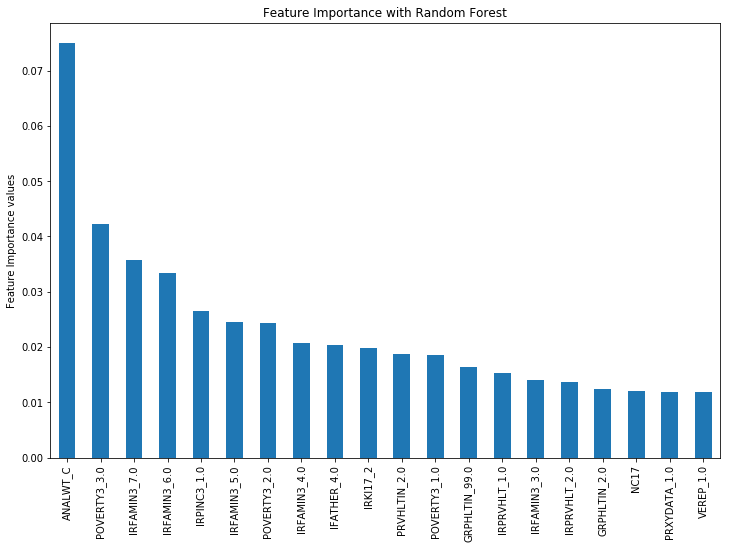

In [178]:
feat_imp[:20].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
#plt.subplots_adjust(bottom=0.25)
#plt.savefig('FeatImportance.png')
plt.show()

In [179]:
imp_feats = list(feat_imp[:20].index)
print(imp_feats)

['ANALWT_C', 'POVERTY3_3.0', 'IRFAMIN3_7.0', 'IRFAMIN3_6.0', 'IRPINC3_1.0', 'IRFAMIN3_5.0', 'POVERTY3_2.0', 'IRFAMIN3_4.0', 'IFATHER_4.0', 'IRKI17_2', 'PRVHLTIN_2.0', 'POVERTY3_1.0', 'GRPHLTIN_99.0', 'IRPRVHLT_1.0', 'IRFAMIN3_3.0', 'IRPRVHLT_2.0', 'GRPHLTIN_2.0', 'NC17', 'PRXYDATA_1.0', 'VEREP_1.0']


### Feature Selection

In [ ]:
# Select From Model
feats = list(X_train.columns.values)

rf = RandomForestClassifier(n_estimators=100, verbose=2, random_state=1, max_depth=20)

# define Boruta feature selection method
feat_selector = SelectFromModel(rf)

# find all relevant features - 20 features should be selected
feat_selector.fit(X_train, y_train)

In [ ]:
sfmodel_feats = [feats[i] for i in feat_selector.get_support(indices=True)]
print(sfmodel_feats)

# Model Training

## Pipeline (AdaBoost, RF, SVM, ET, KNN)

In [180]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
ada = AdaBoostClassifier(base_estimator=et)
gb = GradientBoostingClassifier()
lr = LogisticRegression()

rfe = RFE(rf, step=0.2)
select = SelectFromModel(rf)
kbest = SelectKBest(chi2)

pipe = Pipeline([('feat_sel', rfe), ('model', rf)])

feat_sel_params = [
    {
        'feat_sel': [kbest],
        'feat_sel__k': [20, 30]},
    {
        'feat_sel': [rfe],
        'feat_sel__estimator': [gb], #rf, et, 
        'feat_sel__n_features_to_select': [20]},
    {
        'feat_sel': [select],
        'feat_sel__estimator': [gb]} #rf, et, 
]

model_params = [
    {
        'model': [lr]},
    {
        'model': [gb],
        'model__n_estimators': [20], #500, 1000, 2000, 4000
        'model__learning_rate': [0.5]}, #0.01, 0.04, 0.1, 0.5, 1
    {
        'model': [ada],
        'model__n_estimators': [20], #500, 1000, 2000, 4000
        'model__learning_rate': [0.5], #0.01, 0.04, 0.1, 0.5, 1
        'model__random_state': [2]},
    {
        'model': [rf],
        'model__n_estimators': [20], #500, 1000, 2000, 4000
        'model__criterion': ['gini', 'entropy'],
        'model__max_features': ['sqrt'], #, 'log2'
        'model__min_samples_leaf': [3], #3, 5, 7, 9
        'model__max_depth': [9]}, #8, 10, 14
    {
        'model': [et],
        'model__n_estimators': [20], #500, 1000, 2000, 4000
        'model__criterion': ['gini', 'entropy'],
        'model__max_features': ['sqrt'], #, 'log2'
        'model__min_samples_leaf': [3], #3, 5, 7
        'model__max_depth': [9]} #8, 10, 14
]

params = []
for feat_sel in feat_sel_params:
    for model in model_params:
        # Merge dictionaries and append to list
        params.append({**feat_sel, **model})

In [181]:
grid = GridSearchCV(estimator=pipe, param_grid=params, scoring=make_scorer(matthews_corrcoef), verbose=20, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.9s
[Paralle

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feat_sel', RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'feat_sel': [SelectKBest(k=10, score_func=<function chi2 at 0x00000278FB05A7B8>)], 'feat_sel__k': [20, 30], 'model': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty=...ntropy'], 'model__max_features': ['sqrt'], 'model__min_samples_leaf': [3], 'model__max_depth': [9]}],
       pre_dispatch='2*n_jobs', refit=True, return

In [182]:
# CV results
cv_result_pipe = DataFrame(grid.cv_results_).sort_values('rank_test_score').to_csv('cv_result_pipe.csv', index=False)
print(grid.best_score_)
print(grid.best_estimator_)

0.591819372603
Pipeline(memory=None,
     steps=[('feat_sel', SelectFromModel(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
       ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [183]:
imp_feats = X_train.columns.values[grid.best_params_['feat_sel'].get_support(indices=True)]
print(imp_feats)

['IRKI17_2' 'ANALWT_C' 'NC17' 'IFATHER_2.0' 'IFATHER_4.0' 'PRXYDATA_1.0'
 'MEDICARE_2.0' 'CHAMPUS_85.0' 'PRVHLTIN_1.0' 'PRVHLTIN_2.0'
 'PRVHLTIN_94.0' 'GRPHLTIN_1.0' 'GRPHLTIN_2.0' 'GRPHLTIN_94.0'
 'GRPHLTIN_97.0' 'GRPHLTIN_98.0' 'GRPHLTIN_99.0' 'HLCNOTYR_1.0'
 'IRMEDICR_1.0' 'IRMEDICR_2.0' 'CELLWRKNG_94.0' 'IRFAMSOC_1.0'
 'IIFAMSSI_3.0' 'IRPINC3_1.0' 'IRPINC3_2.0' 'IRPINC3_4.0' 'IRFAMIN3_1.0'
 'IRFAMIN3_2.0' 'IRFAMIN3_3.0' 'IRFAMIN3_4.0' 'IRFAMIN3_5.0' 'IRFAMIN3_6.0'
 'IRFAMIN3_7.0' 'POVERTY3_2.0' 'POVERTY3_3.0' 'TROUBUND_1.0' 'MAIIN102_2.0'
 'VESTR_40033.0' 'VESTR_40043.0' 'HLCALL_2.0' 'HLCALL_196.0']


In [184]:
best_model = grid.best_estimator_.fit(X_train[imp_feats], y_train)
y_pred = best_model.predict(X_test[imp_feats])
# print(y_pred[:4])

print('MCC:', matthews_corrcoef(y_test, y_pred))
print('Acc:', accuracy_score(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))

MCC: 0.460127976352
Acc: 0.941934059464
Confusion Matrix
 [[12439   231]
 [  558   360]]


## Neural Network (sklearn)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
nn = MLPClassifier((100, 25), max_iter=200,tol=0, verbose=10)
nn.fit(X_train, y_train)

In [ ]:
best_model = nn
y_pred = best_model.predict(X_test)
# print(y_pred[:4])

print('MCC:', matthews_corrcoef(y_test, y_pred))
print('Acc:', accuracy_score(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))

### XGBoost

In [ ]:
import xgboost as xgb

# Doing gridsearch to find best params configuration
clf = xgb.XGBClassifier(objective='binary:logistic')

params = {
    'learning_rate': [0.03],   # Learning rate alpha
    'max_depth': [8],   # maximum depth of the tree
    'gamma': [0.1, 0.5],   # minimum eval_score deduction at each split
    'min_child_weight': [3, 6],  # minimum number of datapoints in a split
    'subsample': [0.9],  # sample size row-wise during bootstrap
    'colsample_bytree': [0.5],  # column-wise sample size
    'n_estimators': [100],   # number of trees to build
    }

grid = GridSearchCV(clf, params, cv=5, verbose=50, scoring=make_scorer(matthews_corrcoef), n_jobs=-1)

grid.fit(X_train, y_train)

# CV results
cv_result = DataFrame(grid.cv_results_).to_csv('cv_results_xgb.csv', index=False)

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)

In [ ]:
# imp_feats = X_train.columns.values[grid.best_params_.get_support(indices=True)]
# print(imp_feats)

In [ ]:
# Testing on X_test
xgb_model = grid.best_estimator_.fit(X_train, y_train) #[imp_feats]
y_pred = xgb_model.predict(X_test) #[imp_feats]
print('MCC:', matthews_corrcoef(y_test, y_pred))
print('Acc:', accuracy_score(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))

In [ ]:
# Using best params to find optimum number of iterations
grid_output = grid.best_params_
params = {
    'objective': 'binary:logistic', 
    #'num_class': 2     # num_class not required with the Binary Logistic
    }

best_params = {**grid_output, **params}
#best_params['learning_rate'] = 0.02
print(best_params)

In [ ]:
train_xgb = xgb.DMatrix(X_train, y_train)

from numpy import linspace, array
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    thresholds = linspace(0.01, 0.99, 50)
    mcc = array([matthews_corrcoef(labels, preds>thr) for thr in thresholds])
    best_score = mcc.max()
    return 'mcc', -best_score

cv_results = xgb.cv(best_params, train_xgb, num_boost_round=10000, nfold=5, stratified=True, as_pandas=True, 
                    seed=1, shuffle=True, early_stopping_rounds=20, feval = evalerror, verbose_eval=True)

In [ ]:
nround = cv_results.shape[0]  # Where the best iteration happened
print('Best Iteration:', nround)
xgb_clf = xgb.train(best_params, train_xgb, num_boost_round=nround, verbose_eval=True)

# Predicting on the test set
test_xgb  = xgb.DMatrix(test_xgb_org)
test_pred = xgb_clf.predict(test_xgb)
Class_1, Class_2, Class_3, Class_4, Class_5, Class_6, Class_7, Class_8, Class_9 = map(list, zip(*test_pred))
output = DataFrame({'id': test['id'],
                    'Class_1': Class_1, 
                    'Class_2': Class_2, 
                    'Class_3': Class_3, 
                    'Class_4': Class_4, 
                    'Class_5': Class_5, 
                    'Class_6': Class_6, 
                    'Class_7': Class_7, 
                    'Class_8': Class_8, 
                    'Class_9': Class_9})
output = output[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']]

output.to_csv('output.csv', index=False)
output.head(2)